Attribute means:
yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64

PCA Importance:
    Standard deviation  Proportion of variance  Cumulative proportion
0             0.757050                0.299447               0.299447
1             0.607456                0.192797               0.492244
2             0.504619                0.133045               0.625290
3             0.398799                0.083096               0.708386
4             0.337405                0.059481               0.767866
5             0.310275                0.050300               0.818166
6             0.289697                0.043849               0.862015
7             0.275122                0.039548               0.901563
8             0.265251                0.036761               0.938323
9             0.248842                0.03

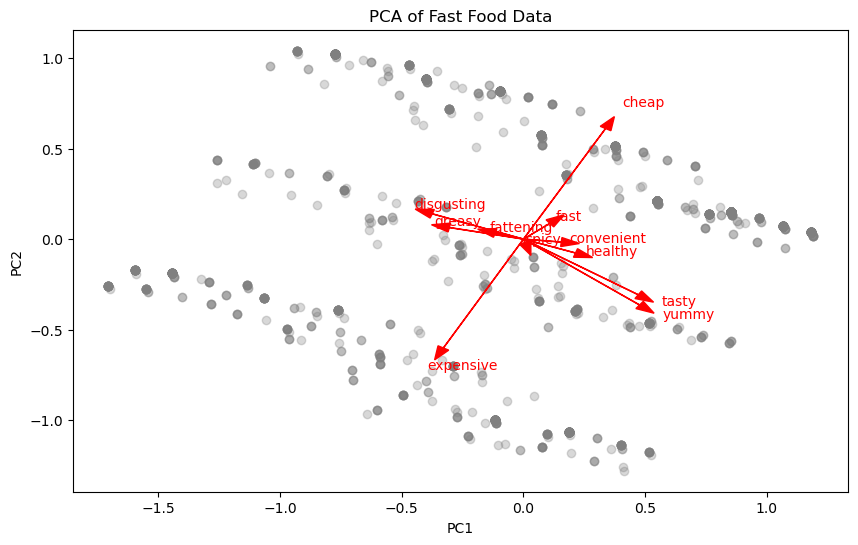

C:\Users\risha\AppData\Local\Temp\ipykernel_20200\2439835781.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(stability_results, labels=range(2, 9))


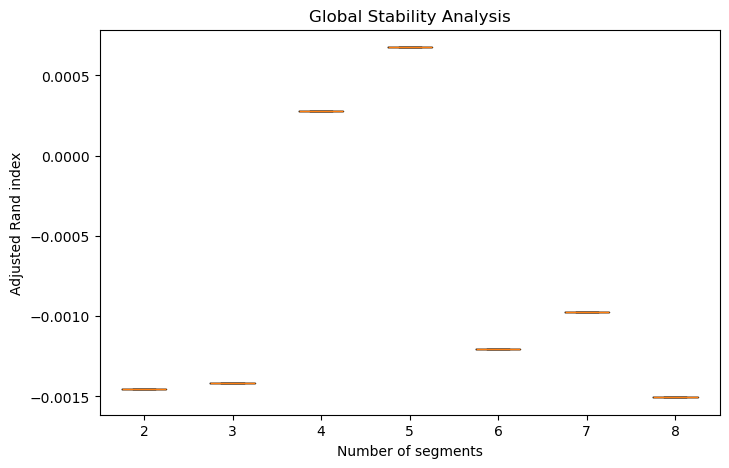

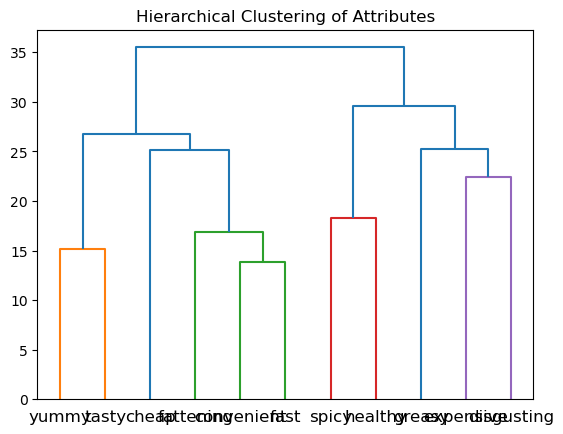

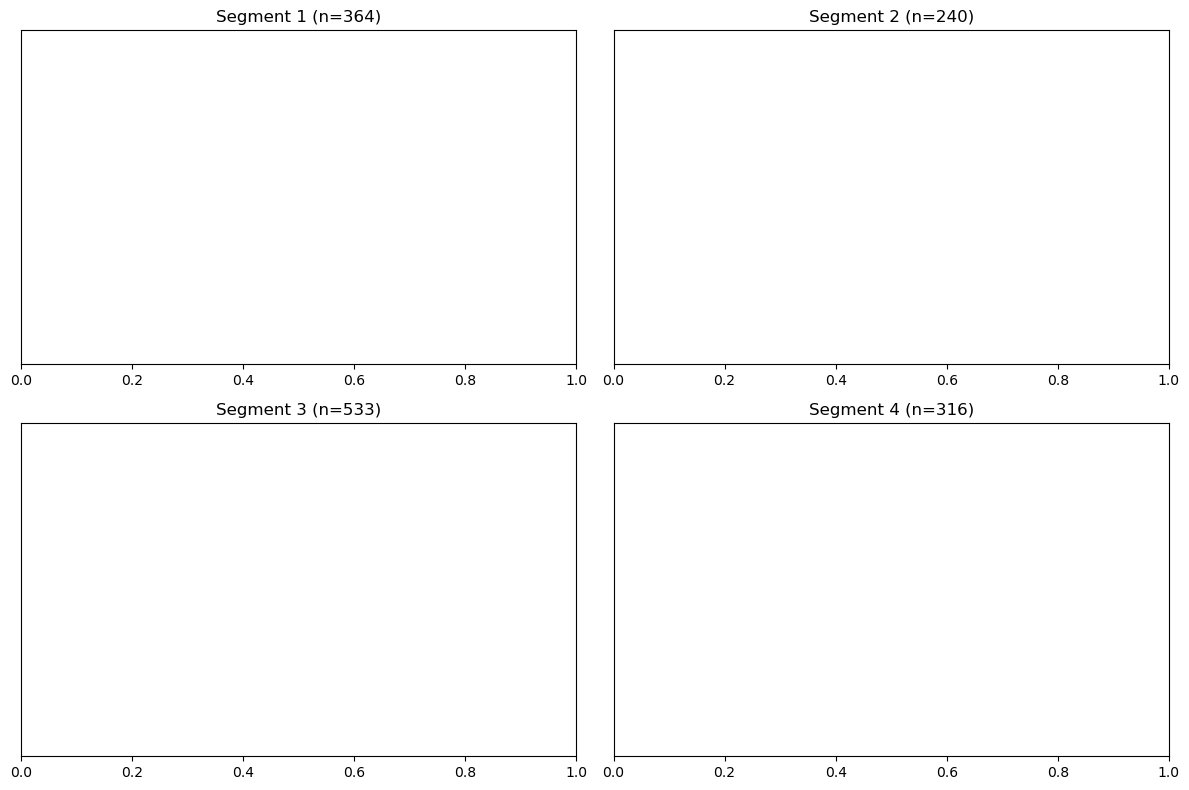

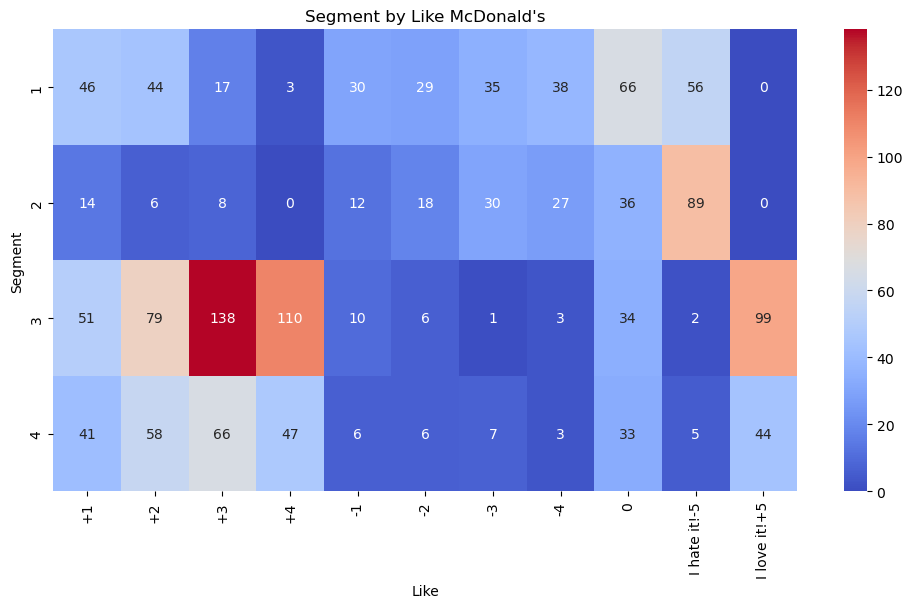

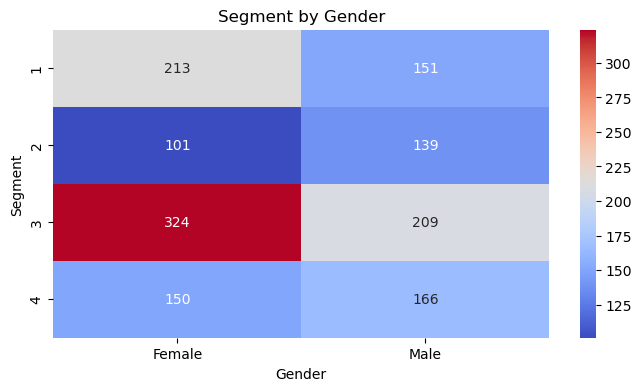

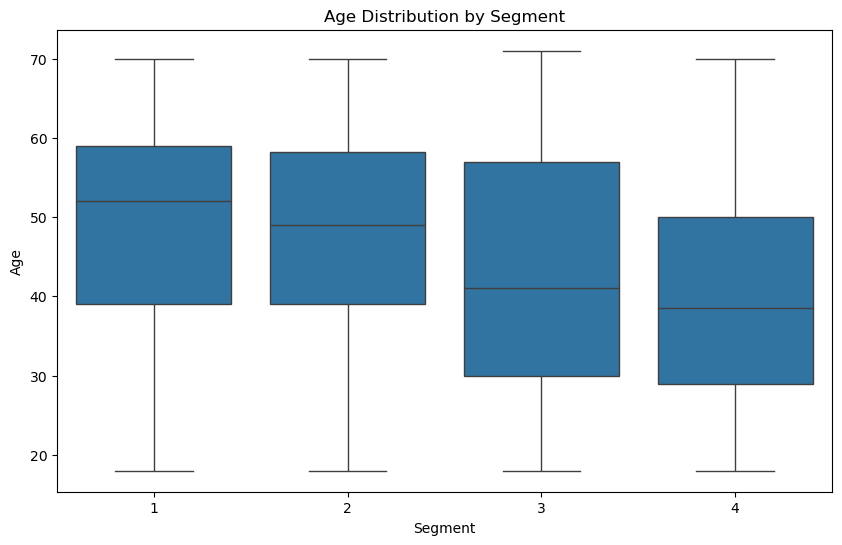

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


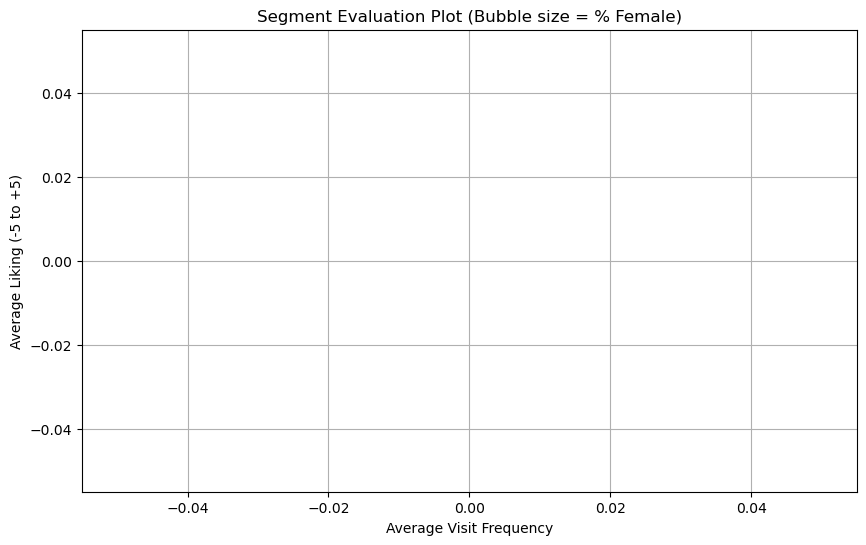

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Load data
mcdonalds = pd.read_csv('mcdonalds.csv')

# Step 3: Data Preparation
binary_columns = mcdonalds.columns[:11]
MD_x = mcdonalds[binary_columns].apply(lambda x: (x == "Yes").astype(int))

# Calculate means of binary variables
print("Attribute means:")
print(MD_x.mean().round(2))

# Step 4: Data Exploration with PCA
pca = PCA()
MD_pca = pca.fit_transform(MD_x)

print("\nPCA Importance:")
print(pd.DataFrame({
    'Standard deviation': np.sqrt(pca.explained_variance_),
    'Proportion of variance': pca.explained_variance_ratio_,
    'Cumulative proportion': np.cumsum(pca.explained_variance_ratio_)
}))

plt.figure(figsize=(10, 6))
plt.scatter(MD_pca[:, 0], MD_pca[:, 1], color='grey', alpha=0.3)
for i, col in enumerate(binary_columns):
    plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], 
              color='red', head_width=0.05)
    plt.text(pca.components_[0, i]*1.2, pca.components_[1, i]*1.2, 
             col, color='red')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Fast Food Data')
plt.show()

# Step 5: K-means Clustering
kmeans4 = KMeans(n_clusters=4, n_init=10, random_state=1234).fit(MD_x)
mcdonalds['Segment'] = kmeans4.labels_ + 1

# Stability analysis
def bootstrap_stability(data, k_range, n_boot=100, random_state=None):
    stability_scores = []
    for k in k_range:
        ari_scores = []
        for _ in range(n_boot):
            sample = resample(data, replace=True, random_state=random_state)
            kmeans_ref = KMeans(n_clusters=k, n_init=10, random_state=random_state).fit(data)
            kmeans_sample = KMeans(n_clusters=k, n_init=10, random_state=random_state).fit(sample)
            ari = adjusted_rand_score(kmeans_ref.labels_, kmeans_sample.labels_)
            ari_scores.append(ari)
        stability_scores.append(ari_scores)
    return stability_scores

stability_results = bootstrap_stability(MD_x, range(2, 9), random_state=1234)

plt.figure(figsize=(8, 5))
plt.boxplot(stability_results, labels=range(2, 9))
plt.xlabel('Number of segments')
plt.ylabel('Adjusted Rand index')
plt.title('Global Stability Analysis')
plt.show()

# Select 4-segment solution
kmeans4 = KMeans(n_clusters=4, n_init=10, random_state=1234).fit(MD_x)
mcdonalds['Segment'] = kmeans4.labels_ + 1

# Step 6: Profiling Segments
linkage_matrix = linkage(pdist(MD_x.T), method='complete')
dendrogram(linkage_matrix, labels=binary_columns)
plt.title('Hierarchical Clustering of Attributes')
plt.show()

# Ensure `segment_profiles` index is numeric
segment_profiles.index = segment_profiles.index.astype(int)

plt.figure(figsize=(12, 8))
for i, segment in enumerate(segment_profiles.index):
    plt.subplot(2, 2, i+1)
    
    # Ensure `var_order` exists in segment_profiles
    segment_data = segment_profiles.loc[segment, segment_profiles.columns.intersection(var_order)]
    overall_mean = MD_x.mean()[segment_profiles.columns.intersection(var_order)]
    
    marker_vars = ((abs(segment_data - overall_mean) > 0.25) | 
                   ((abs(segment_data - overall_mean) / overall_mean) > 0.5))
    
    colors = ['red' if marker else 'gray' for marker in marker_vars]
    
    plt.barh(range(len(segment_data)), segment_data, color=colors)
    plt.yticks(range(len(segment_data)), segment_data.index)
    plt.vlines(overall_mean.values, -0.5, len(segment_data)-0.5, linestyles='dashed')
    plt.title(f'Segment {segment} (n={(mcdonalds["Segment"]==segment).sum()})')
    plt.xlim(0, 1)

plt.tight_layout()
plt.show()
# Step 7: Describing Segments
mcdonalds['Like_n'] = 6 - mcdonalds['Like'].astype('category').cat.codes

like_table = pd.crosstab(mcdonalds['Segment'], mcdonalds['Like'])
plt.figure(figsize=(12, 6))
sns.heatmap(like_table, annot=True, fmt='d', cmap='coolwarm')
plt.title('Segment by Like McDonald\'s')
plt.show()

gender_table = pd.crosstab(mcdonalds['Segment'], mcdonalds['Gender'])
plt.figure(figsize=(8, 4))
sns.heatmap(gender_table, annot=True, fmt='d', cmap='coolwarm')
plt.title('Segment by Gender')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Segment', y='Age', data=mcdonalds)
plt.title('Age Distribution by Segment')
plt.show()

# Step 8: Selecting Target Segments
segment_stats = mcdonalds.groupby('Segment').agg({
    'VisitFrequency': lambda x: pd.to_numeric(x, errors='coerce').mean(),
    'Like_n': 'mean',
    'Gender': lambda x: (x == 'Female').mean()
})

plt.figure(figsize=(10, 6))
plt.scatter(
    x=segment_stats['VisitFrequency'],
    y=segment_stats['Like_n'],
    s=segment_stats['Gender']*1000,
    alpha=0.6
)

for i in segment_stats.index:
    plt.text(
        x=segment_stats.loc[i, 'VisitFrequency'],
        y=segment_stats.loc[i, 'Like_n'],
        s=str(i),
        ha='center', va='center'
    )

plt.xlabel('Average Visit Frequency')
plt.ylabel('Average Liking (-5 to +5)')
plt.title('Segment Evaluation Plot (Bubble size = % Female)')
plt.grid()
plt.show()



Attribute means:
yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64

PCA Importance:
    Standard deviation  Proportion of variance  Cumulative proportion
0               0.7570                  0.2994                 0.2994
1               0.6075                  0.1928                 0.4922
2               0.5046                  0.1330                 0.6253
3               0.3988                  0.0831                 0.7084
4               0.3374                  0.0595                 0.7679
5               0.3103                  0.0503                 0.8182
6               0.2897                  0.0438                 0.8620
7               0.2751                  0.0395                 0.9016
8               0.2653                  0.0368                 0.9383
9               0.2488                  0

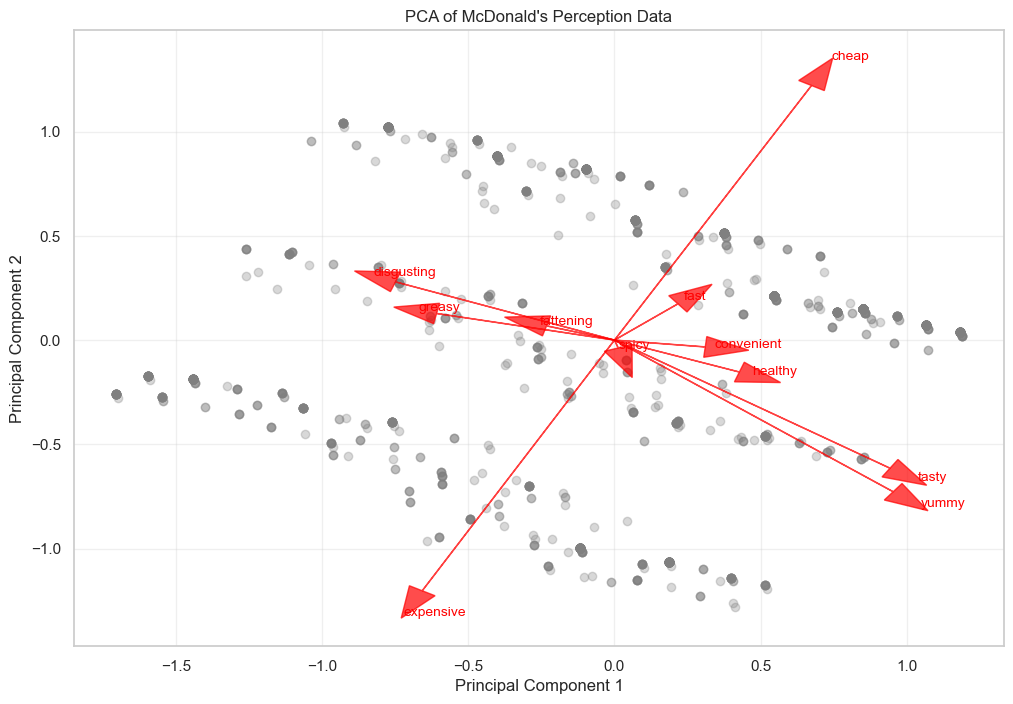

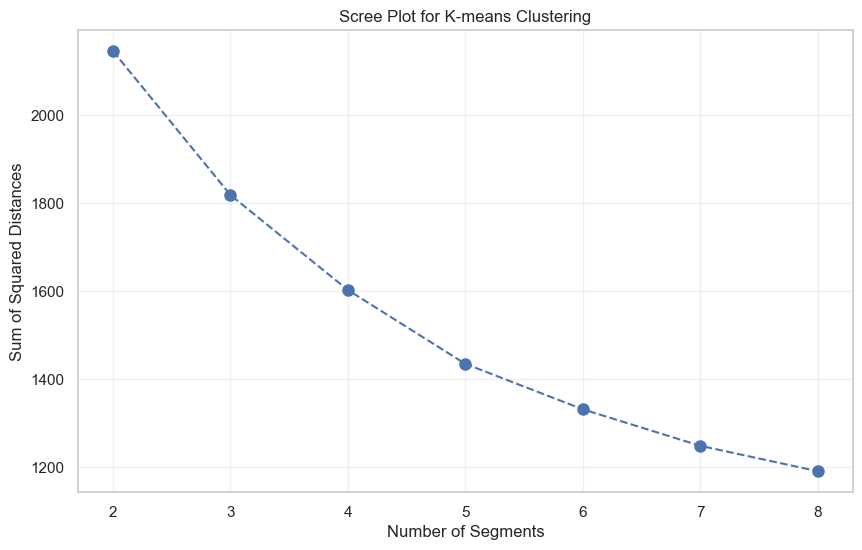

C:\Users\risha\AppData\Local\Temp\ipykernel_20200\884507853.py:98: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(stability_results, labels=range(2, 9), patch_artist=True)


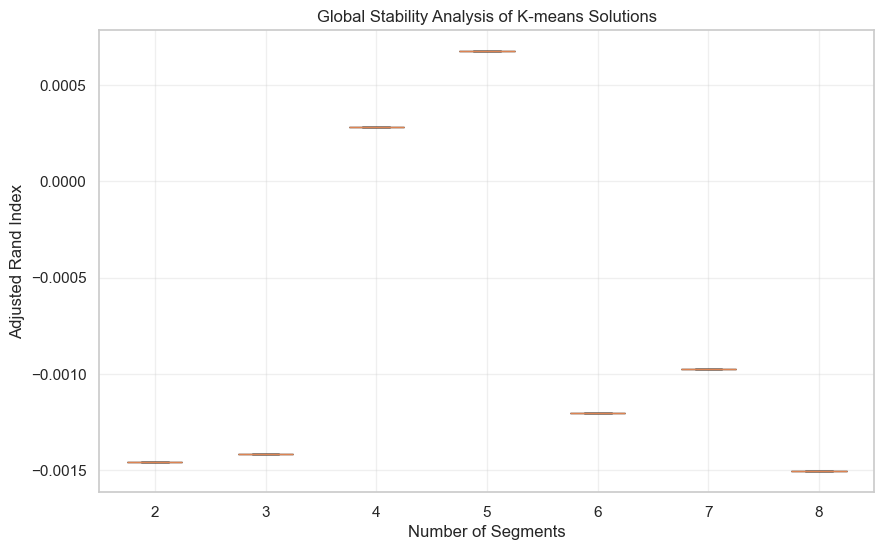

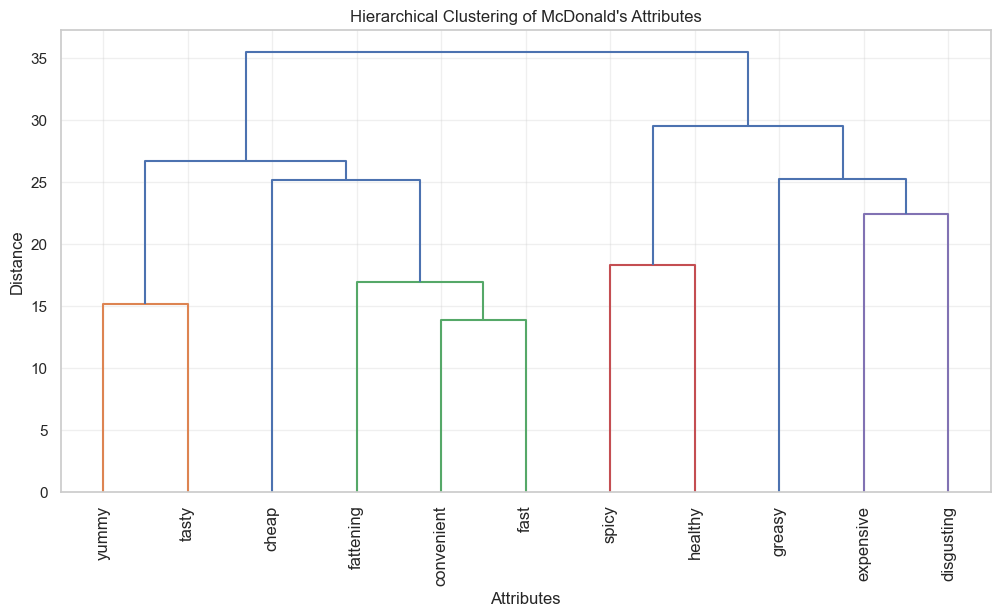

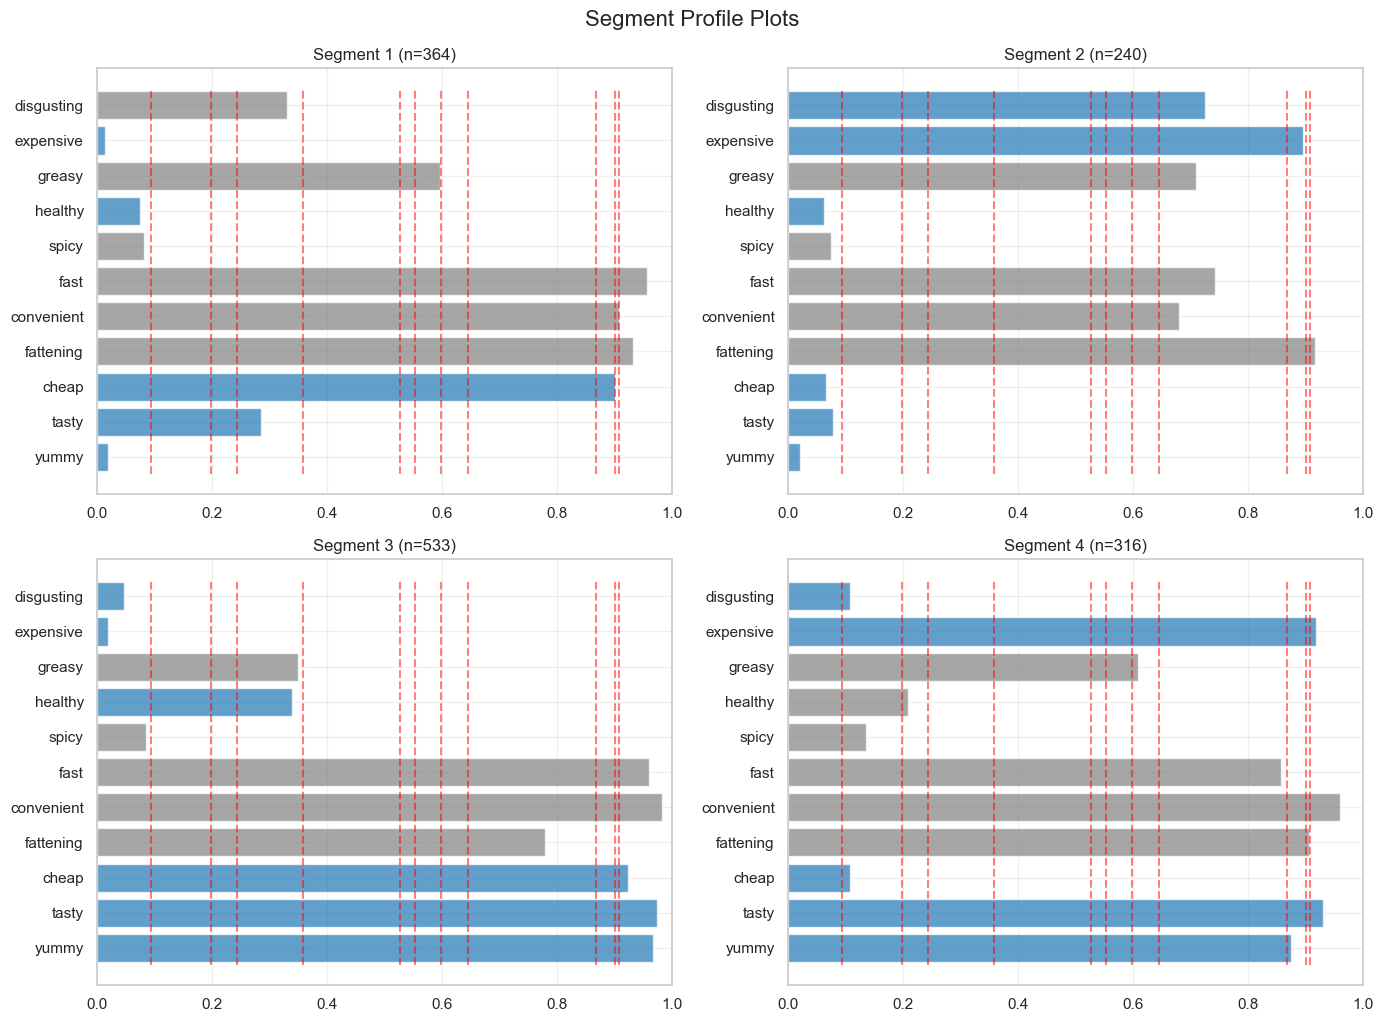

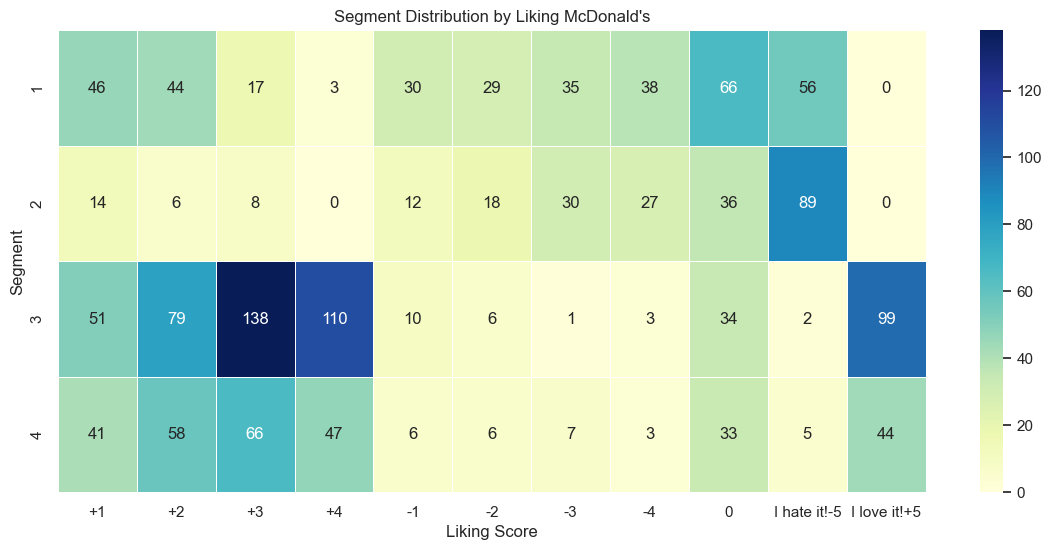

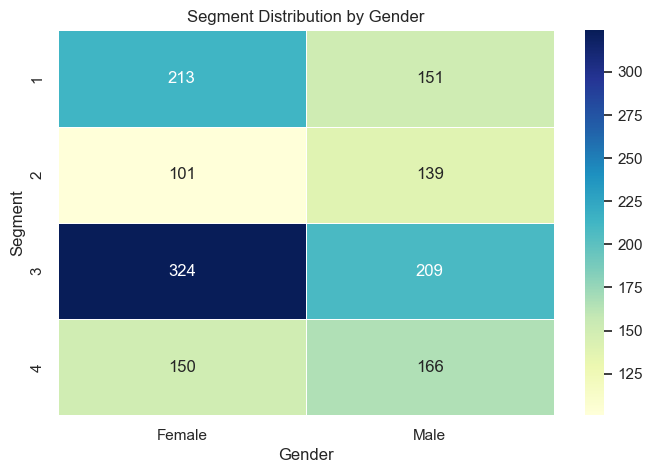

C:\Users\risha\AppData\Local\Temp\ipykernel_20200\884507853.py:182: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Segment', y='Age', data=mcdonalds, palette='Set2')


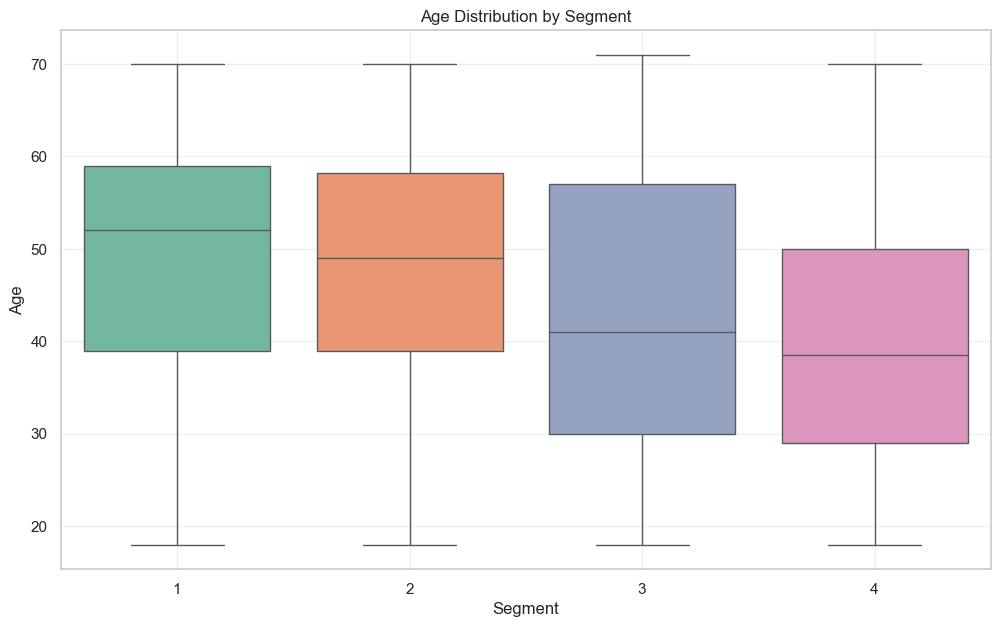

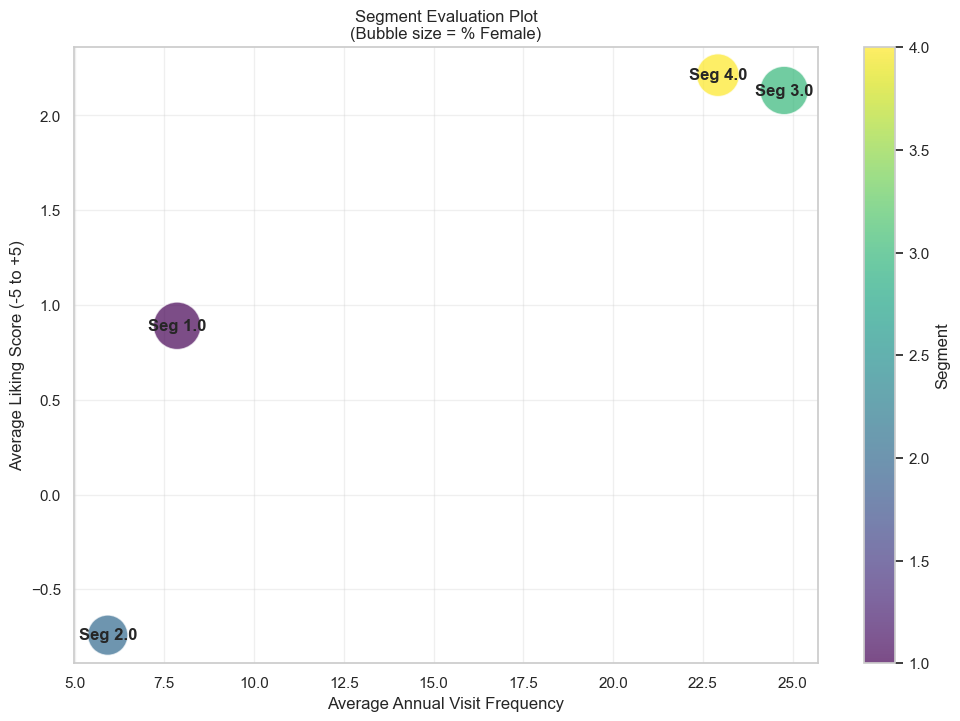

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from sklearn.tree import DecisionTreeClassifier

# Set style for better visualizations
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

def load_and_prepare_data():
    """Load and prepare the McDonald's dataset"""
    try:
        mcdonalds = pd.read_csv('mcdonalds.csv')
    except FileNotFoundError:
        print("Error: 'mcdonalds.csv' file not found.")
        return None, None
    
    # Convert Yes/No to binary (1/0)
    binary_columns = mcdonalds.columns[:11]
    MD_x = mcdonalds[binary_columns].apply(lambda x: (x == "Yes").astype(int))
    
    return mcdonalds, MD_x

def perform_pca_analysis(MD_x):
    """Perform PCA analysis and visualization"""
    pca = PCA()
    MD_pca = pca.fit_transform(MD_x)
    
    # PCA Summary
    print("\nPCA Importance:")
    print(pd.DataFrame({
        'Standard deviation': np.sqrt(pca.explained_variance_),
        'Proportion of variance': pca.explained_variance_ratio_,
        'Cumulative proportion': np.cumsum(pca.explained_variance_ratio_)
    }).round(4))
    
    # Plot PCA loadings
    plt.figure(figsize=(12, 8))
    plt.scatter(MD_pca[:, 0], MD_pca[:, 1], color='grey', alpha=0.3)
    for i, col in enumerate(MD_x.columns):
        plt.arrow(0, 0, pca.components_[0, i]*2, pca.components_[1, i]*2, 
                  color='red', head_width=0.1, alpha=0.7)
        plt.text(pca.components_[0, i]*2.2, pca.components_[1, i]*2.2, 
                 col, color='red', fontsize=10)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of McDonald\'s Perception Data')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return pca, MD_pca

def perform_clustering(MD_x):
    """Perform K-means clustering with stability analysis"""
    # K-means for 2-8 segments
    inertias = []
    for k in range(2, 9):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=1234)
        kmeans.fit(MD_x)
        inertias.append(kmeans.inertia_)

    # Scree plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, 9), inertias, marker='o', markersize=8, linestyle='--')
    plt.xlabel('Number of Segments')
    plt.ylabel('Sum of Squared Distances')
    plt.title('Scree Plot for K-means Clustering')
    plt.xticks(range(2, 9))
    plt.grid(True, alpha=0.3)
    plt.show()

    # Stability analysis
    def bootstrap_stability(data, k_range, n_boot=100, random_state=None):
        stability_scores = []
        for k in k_range:
            ari_scores = []
            for _ in range(n_boot):
                sample = resample(data, replace=True, random_state=random_state)
                kmeans_ref = KMeans(n_clusters=k, n_init=10, random_state=random_state).fit(data)
                kmeans_sample = KMeans(n_clusters=k, n_init=10, random_state=random_state).fit(sample)
                ari = adjusted_rand_score(kmeans_ref.labels_, kmeans_sample.labels_)
                ari_scores.append(ari)
            stability_scores.append(ari_scores)
        return stability_scores

    stability_results = bootstrap_stability(MD_x, range(2, 9), random_state=1234)

    # Plot stability
    plt.figure(figsize=(10, 6))
    plt.boxplot(stability_results, labels=range(2, 9), patch_artist=True)
    plt.xlabel('Number of Segments')
    plt.ylabel('Adjusted Rand Index')
    plt.title('Global Stability Analysis of K-means Solutions')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Select 4-segment solution
    kmeans4 = KMeans(n_clusters=4, n_init=10, random_state=1234).fit(MD_x)
    return kmeans4

def analyze_segments(mcdonalds, MD_x, kmeans4):
    """Analyze and visualize the segments"""
    mcdonalds['Segment'] = kmeans4.labels_ + 1
    
    # Reorder variables using hierarchical clustering
    linkage_matrix = linkage(pdist(MD_x.T), method='complete')
    plt.figure(figsize=(12, 6))
    dendrogram(linkage_matrix, labels=MD_x.columns, leaf_rotation=90)
    plt.title('Hierarchical Clustering of McDonald\'s Attributes')
    plt.xlabel('Attributes')
    plt.ylabel('Distance')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Get variable order from dendrogram
    dendro_info = dendrogram(linkage_matrix, no_plot=True)
    var_order = [MD_x.columns[int(i)] for i in dendro_info['ivl']]
    
    # Segment profile plot
    segment_profiles = MD_x.groupby(mcdonalds['Segment']).mean()
    segment_counts = mcdonalds['Segment'].value_counts().sort_index()

    plt.figure(figsize=(14, 10))
    for i, segment in enumerate(segment_profiles.index):
        plt.subplot(2, 2, i+1)
        segment_data = segment_profiles.loc[segment][var_order]
        overall_mean = MD_x.mean()[var_order]
        
        # Calculate marker variables
        marker_vars = ((abs(segment_data - overall_mean) > 0.25) | 
                      ((abs(segment_data - overall_mean)/overall_mean) > 0.5))
        
        colors = ['#1f77b4' if marker else 'gray' for marker in marker_vars]
        
        plt.barh(var_order, segment_data, color=colors, alpha=0.7)
        plt.vlines(overall_mean.values, -0.5, len(var_order)-0.5, 
                   linestyles='dashed', colors='red', alpha=0.5)
        plt.title(f'Segment {segment} (n={segment_counts[segment]})')
        plt.xlim(0, 1)
        plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.suptitle('Segment Profile Plots', fontsize=16, y=1.02)
    plt.show()
    
    return mcdonalds, var_order

def describe_segments(mcdonalds):
    """Describe segments using additional variables"""
    # Convert Like to numeric (-5 to +5 scale)
    mcdonalds['Like_n'] = 6 - mcdonalds['Like'].astype('category').cat.codes

    # Heatmap for Like
    like_table = pd.crosstab(mcdonalds['Segment'], mcdonalds['Like'])
    plt.figure(figsize=(14, 6))
    sns.heatmap(like_table, annot=True, fmt='d', cmap='YlGnBu', 
                linewidths=0.5, linecolor='white')
    plt.title('Segment Distribution by Liking McDonald\'s')
    plt.xlabel('Liking Score')
    plt.ylabel('Segment')
    plt.show()

    # Heatmap for Gender
    gender_table = pd.crosstab(mcdonalds['Segment'], mcdonalds['Gender'])
    plt.figure(figsize=(8, 5))
    sns.heatmap(gender_table, annot=True, fmt='d', cmap='YlGnBu', 
                linewidths=0.5, linecolor='white')
    plt.title('Segment Distribution by Gender')
    plt.xlabel('Gender')
    plt.ylabel('Segment')
    plt.show()

    # Age distribution by segment
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='Segment', y='Age', data=mcdonalds, palette='Set2')
    plt.title('Age Distribution by Segment')
    plt.xlabel('Segment')
    plt.ylabel('Age')
    plt.grid(True, alpha=0.3)
    plt.show()

def evaluate_segments(mcdonalds):
    """Evaluate and visualize segment attractiveness"""
    visit_freq_mapping = {
        'Never': 0,
        'Once a year': 1,
        'Every three months': 4,
        'Once a month': 12,
        'Once a week': 52,
        'More than once a week': 104
    }

    mcdonalds['VisitFrequency_n'] = mcdonalds['VisitFrequency'].map(visit_freq_mapping)

    segment_stats = mcdonalds.groupby('Segment').agg({
        'VisitFrequency_n': 'mean',
        'Like_n': 'mean',
        'Gender': lambda x: (x == 'Female').mean()
    }).reset_index()

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        x=segment_stats['VisitFrequency_n'],
        y=segment_stats['Like_n'],
        s=segment_stats['Gender']*2000,
        c=segment_stats['Segment'],
        cmap='viridis',
        alpha=0.7,
        edgecolors='w',
        linewidth=1
    )

    for i, row in segment_stats.iterrows():
        plt.text(
            x=row['VisitFrequency_n'],
            y=row['Like_n'],
            s=f"Seg {row['Segment']}",
            ha='center', 
            va='center',
            fontsize=12,
            fontweight='bold'
        )

    plt.xlabel('Average Annual Visit Frequency')
    plt.ylabel('Average Liking Score (-5 to +5)')
    plt.title('Segment Evaluation Plot\n(Bubble size = % Female)')
    plt.grid(True, alpha=0.3)

    cbar = plt.colorbar(scatter)
    cbar.set_label('Segment')

    plt.show()

def main():
    """Main function to run the analysis"""
    # Load and prepare data
    mcdonalds, MD_x = load_and_prepare_data()
    if mcdonalds is None:
        return
    
    # Print attribute means
    print("\nAttribute means:")
    print(MD_x.mean().round(2))
    
    # Perform PCA analysis
    perform_pca_analysis(MD_x)
    
    # Perform clustering
    kmeans4 = perform_clustering(MD_x)
    
    # Analyze segments
    mcdonalds, var_order = analyze_segments(mcdonalds, MD_x, kmeans4)
    
    # Describe segments
    describe_segments(mcdonalds)
    
    # Evaluate segments
    evaluate_segments(mcdonalds)

if __name__ == "__main__":
    main()